# Time Series Forecasting Using ARIMA/SARIMA Model
## Stock Market
### Hoa Nguyen

### A. Introduction
#### 1. Time Series Forecasting

> + Time series forecasting is the process of using statistical models to predict future values of a time series based on past results.
>
> + Forecasting a time series can be divided into two types:
>
>       If you use previous values of a time series to predict its future values, it is called Univariate Time Series Forecasting.
>
>       If you use predictors other than the series (such as exogenous variables) to forecast, it is called Multivariate Time Series Forecasting.
>
> + This code focuses on a specific type of forecasting method called the ARIMA model.

#### 2. ARIMA Model

> + ARIMA stands for Autoregressive Integrated Moving Average Model. It belongs to a class of models that explains a given time series based on its own past values -i.e.- its own lags and the lagged forecast
errors. The equation can be used to forecast future values. Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.
>
> + So, ARIMA, short for AutoRegressive Integrated Moving Average, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.
>
> + ARIMA Models are specified by three order parameters: (p, d, q), where:
>
>        p is the order of the AR term
>
>        q is the order of the MA term
>
>        d is the number of differencing required to make the time series stationary
>
> + AR(p) Autoregression – a regression model that utilizes the dependent relationship between a current observation and observations over a previous period. An auto regressive (AR(p)) component refers to the use of past values in the regression equation for the time series.
>
> + I(d) Integration – uses differencing of observations (subtracting an observation from observation at the previous time step) in order to make the time series stationary. Differencing involves the subtraction of the current values of a series with its previous values d number of times.
>
> + MA(q) Moving Average – a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. A moving average component depicts the error of the model as a combination of previous error terms. The order q represents the number of terms to be included in the model.

> Types of ARIMA Model:
>
>       ARIMA : Non-seasonal Autoregressive Integrated Moving Averages
>
>       SARIMA : Seasonal ARIMA
>
>       SARIMAX : Seasonal ARIMA with exogenous variables
>
> If a time series, has seasonal patterns, then we need to add seasonal terms and it becomes SARIMA, short for Seasonal ARIMA.

### B. Time Series Forecasting
#### 1. Import Library

In [372]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

#### 2. Load Data
> This data is private so we cannot make it public to you.

In [373]:
stock = pd.read_csv('a.us.csv')
stock['Date'] = pd.to_datetime(stock['Date'])
stock.set_index('Date', inplace=True)
stock.head(10)

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1999-11-18,30.713,33.754,27.002,29.702,66277506,0
1999-11-19,28.986,29.027,26.872,27.257,16142920,0
1999-11-22,27.886,29.702,27.044,29.702,6970266,0
1999-11-23,28.688,29.446,27.002,27.002,6332082,0
1999-11-24,27.083,28.309,27.002,27.717,5132147,0
1999-11-26,27.594,28.012,27.509,27.807,1832635,0
1999-11-29,27.676,28.650,27.380,28.432,4317826,0
1999-11-30,28.350,28.986,27.634,28.480,4567146,0
1999-12-01,28.480,29.324,28.273,28.986,3133746,0


#### 3. Transform Data & Visualization

> We only work with "Closing Price" and predict it.

Text(0.5, 1.0, 'Closing Price')

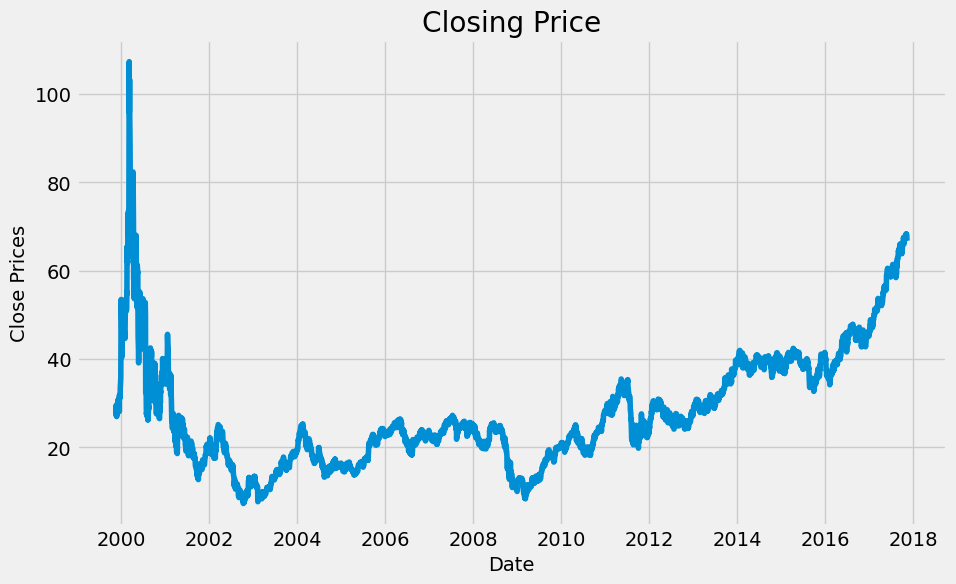

In [374]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock['Close'])
plt.title('Closing Price')

In [376]:
#Resample the data as it contains too much variations
# Aggregate by month and average stock prices in each month
ts_m = stock['Close'].resample('M').mean()
df = ts_m


> Resample by Week and then forecasting

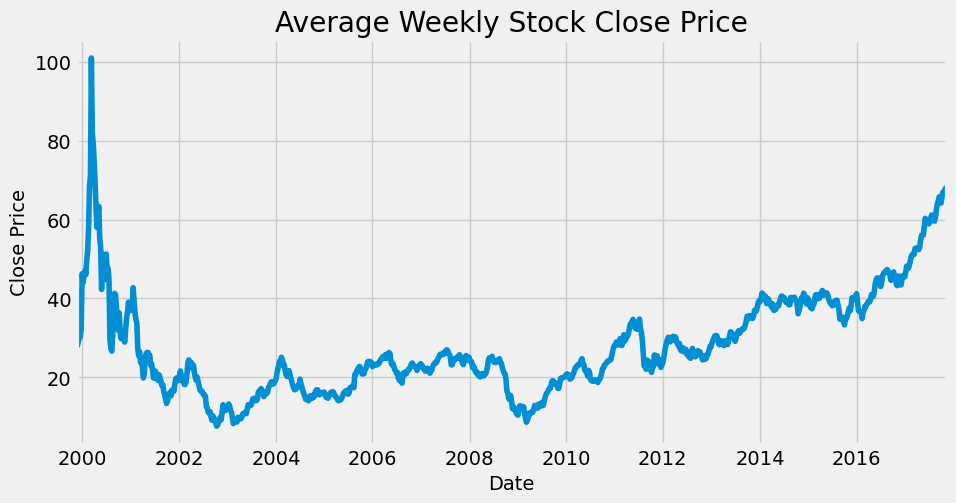

In [375]:
#Resample the data as it contains too much variations
# Aggregate by week and average stock prices in each week
ts_week = stock['Close'].resample('W').mean()
# Draw charts
plt.figure(figsize=(10, 5))
ts_week.plot(title='Average Weekly Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show(1)

> Check Stationary from the data !

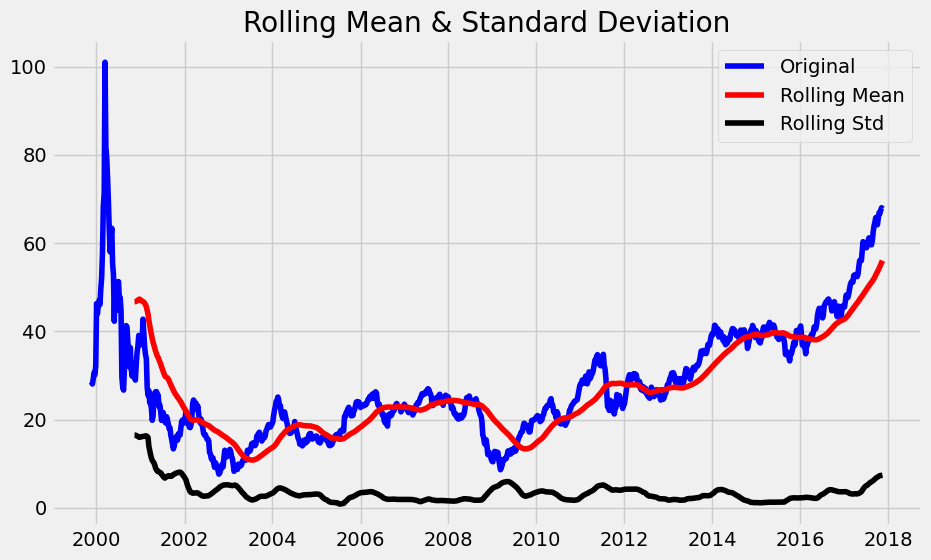

Results of Dickey-Fuller Test:
Test Statistic                  -0.497938
p-value                          0.892418
#Lags Used                      22.000000
Number of Observations Used    916.000000
Critical Value (1%)             -3.437509
Critical Value (5%)             -2.864700
Critical Value (10%)            -2.568453
dtype: float64


In [138]:
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()
    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(ts_week)

> + From the graph above, we see that mean and std are not constant over time and p-value = 0.89 > 0.05, so we conclude that this data is not stationary!
>
> + With non-stationary data, we need to remove train and seasonal when training the model!

##### Get log data for reduce data domain

> We start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series.

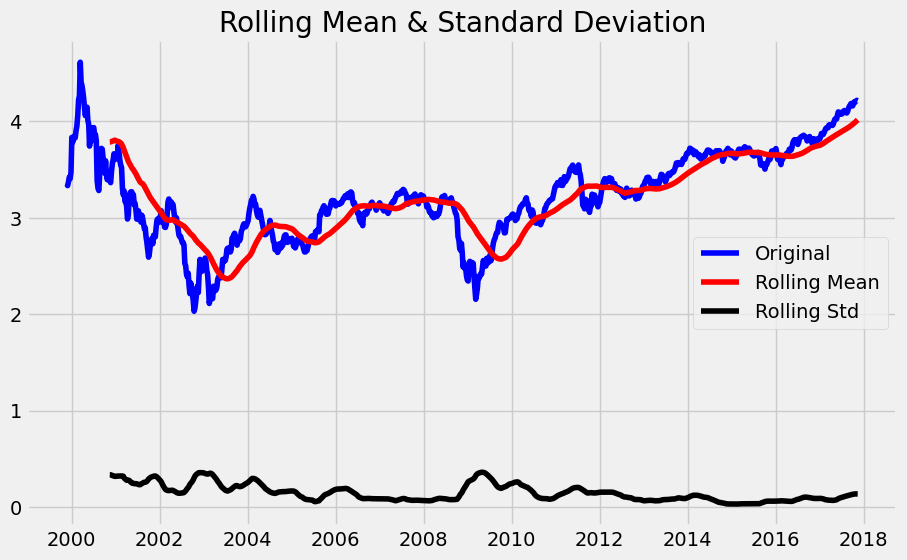

Results of Dickey-Fuller Test:
Test Statistic                  -1.527613
p-value                          0.519810
#Lags Used                       4.000000
Number of Observations Used    934.000000
Critical Value (1%)             -3.437371
Critical Value (5%)             -2.864639
Critical Value (10%)            -2.568420
dtype: float64


In [140]:
test_stationarity(np.log(ts_week)) # get log -> Reduce data domain

In [141]:
df_log = np.log(ts_week)

##### Currently, we only work with df_lod

> Use ACF & PACF to check stationary ( can be used to select d,p,q for the model )

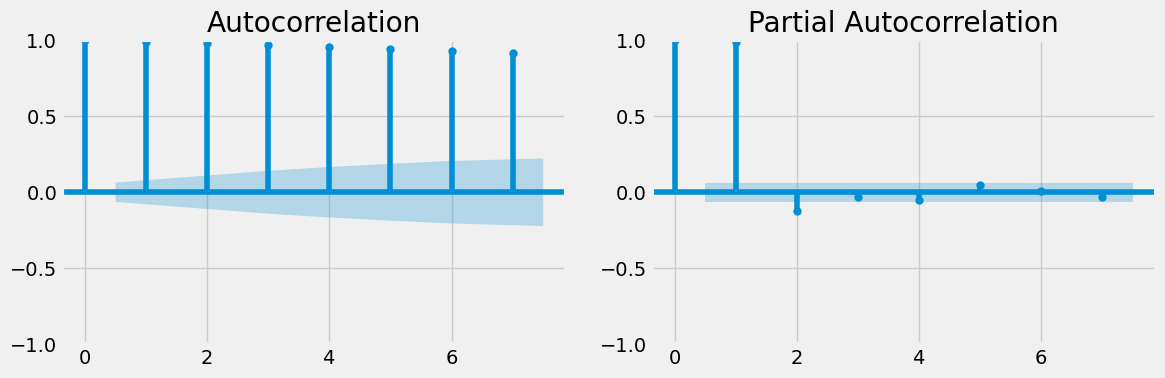

In [142]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(df_log, lags=7, ax=axes[0])
smt.graphics.plot_pacf(df_log, lags=7, ax=axes[1])
plt.tight_layout()

> If you don't use the test_stationary function, from the ADF and PACF graphs above, we can see that this data has not eliminated train and seasonal (this data is non-stationary).
>
> We can determine the best model is (1,1,0) or (0,1,1) from the graph above (you can run a test to know the best model)
>
> In addition, we can use auto_ARIMA to let the model automatically find the best model!

#### 4. Build ARIMA Model

> Split training and testing (80:20)

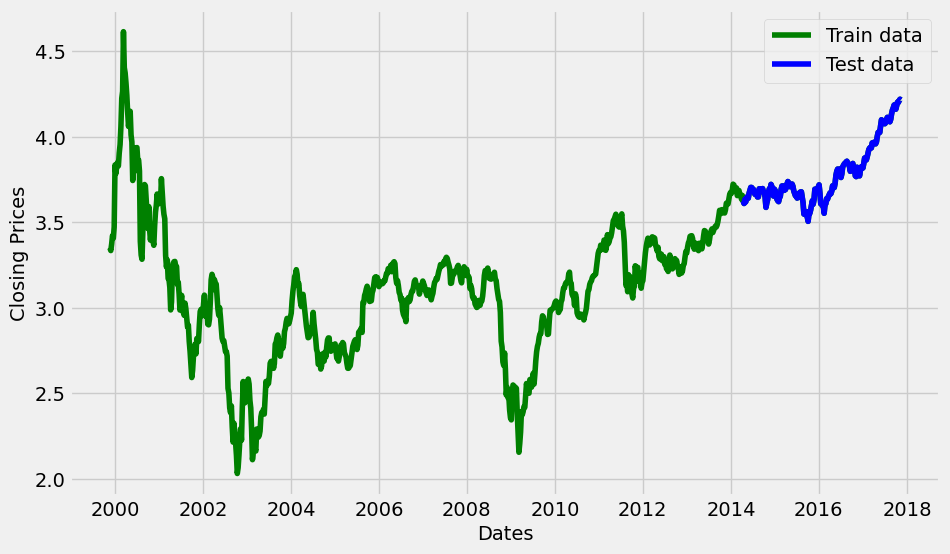

In [143]:
#split data into train and training set
train_data, test_data = df_log[0:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

> Finding the best parameters (p,q and d)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=inf, Time=56.36 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=-1595.893, Time=0.75 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=-1827.217, Time=25.85 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=123.97 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=-1624.258, Time=0.90 sec
 ARIMA(1,1,0)(2,1,0)[52]             : AIC=inf, Time=168.85 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=115.19 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=101.59 sec
 ARIMA(1,1,0)(2,1,1)[52]             : AIC=inf, Time=428.52 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=-1809.095, Time=28.42 sec
 ARIMA(2,1,0)(1,1,0)[52]             : AIC=-1825.218, Time=50.66 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=-1825.165, Time=30.50 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=-1827.170, Time=22.01 sec
 ARIMA(2,1,1)(1,1,0)[52]             : AIC=-1823.240, Time=43.96 sec
 ARIMA(1,1,0)(1,1,0)[52]

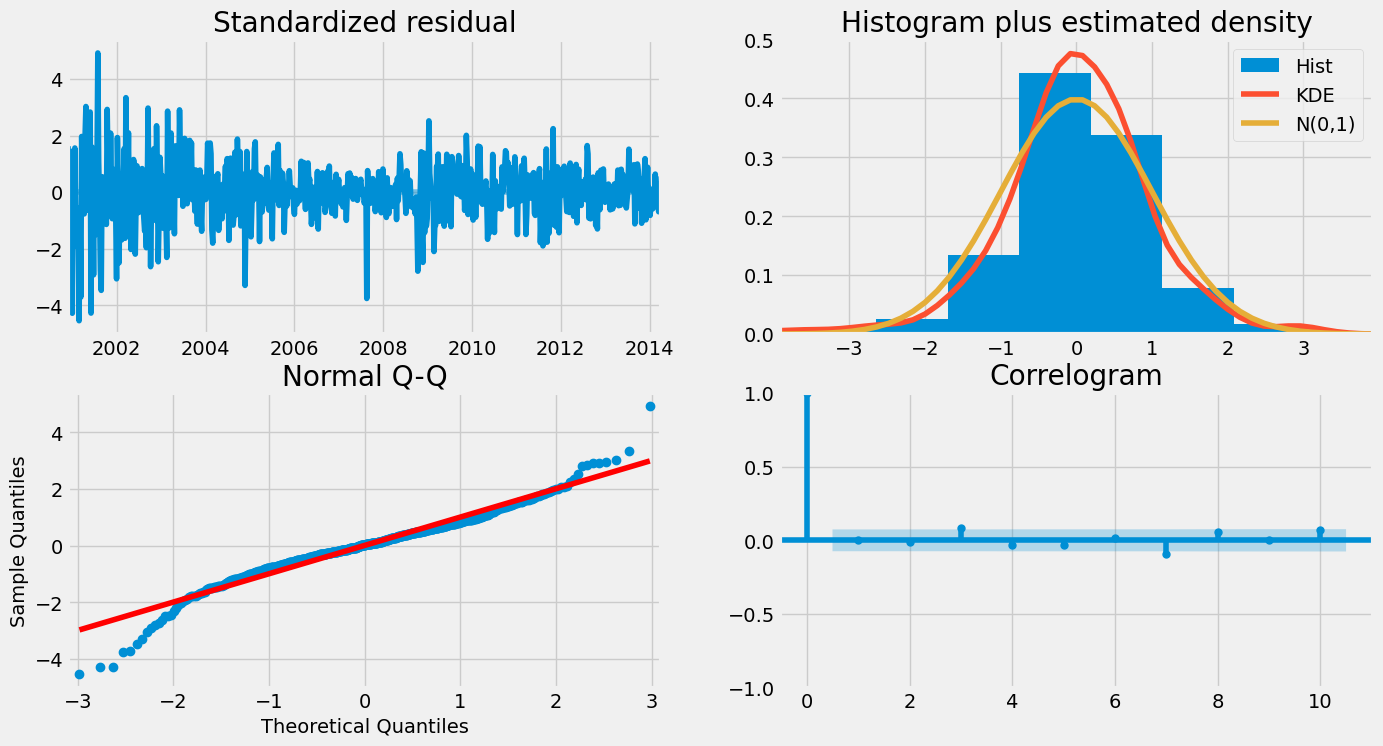

In [144]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=52,             # frequency of series
                      d=None,           # let model determine 'd'
                      D=1,
                      seasonal= True,
                      start_P=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True
                      )
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()


> Best parameters: (1,1,0)

##### Using best parameters to build model

> Using SARIMAX model (this model is "ARIMA plus seasonal")

In [173]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Create and train ARIMA model
model = SARIMAX(train_data, order=(1,1,0))  
fitted = model.fit()  # Remove the 'disp' parameter
print(fitted.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.46104D+00    |proj g|=  2.52708D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2     11      1     0     0   9.718D-04  -1.461D+00
  F =  -1.4610400524193119     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  751
Model:               SARIMAX(1, 1, 0

 This problem is unconstrained.


##### Draw a stock price prediction model using sarimax

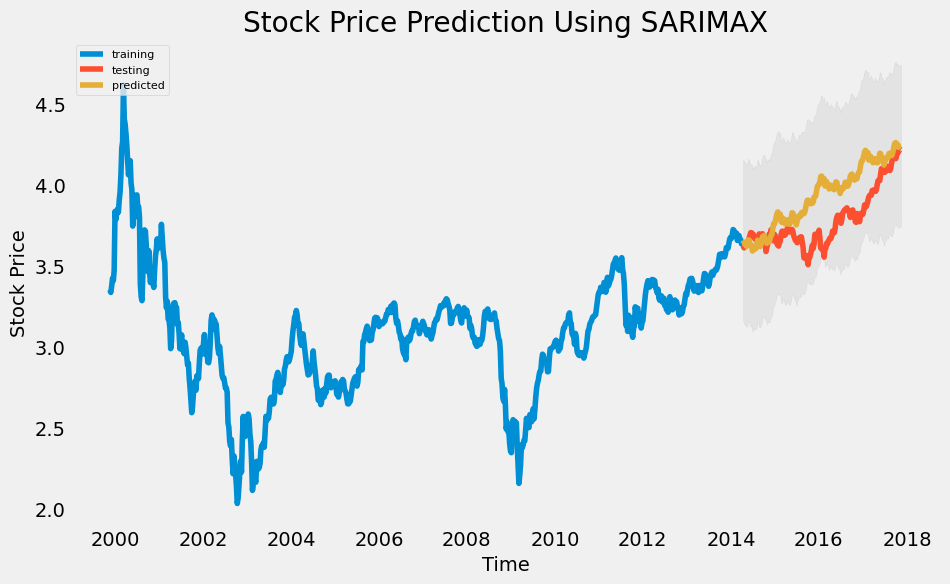

In [179]:
# Make as pandas series
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dự đoán và tính khoảng tin cậy
fc, confint = model_autoARIMA.predict(n_periods=len(test_data), return_conf_int=True, conf_int_level=0.9)

# Chuyển đổi dự đoán thành Pandas Series
fc_series = pd.Series(fc, index=test_data.index)

# Tính toán và tạo Pandas Series cho khoảng tin cậy hẹp hơn
margin_of_error = 0.5  # điều chỉnh độ rộng của khoảng tin cậy
lower_series = fc_series - margin_of_error
upper_series = fc_series + margin_of_error

# Visualize
plt.plot(train_data, label= 'training')
plt.plot(test_data, label = 'testing')
plt.plot(fc_series,label='predicted')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha =.05)
plt.grid(False)
plt.title('Stock Price Prediction Using SARIMAX')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### The above model gives quite good results!

In [174]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, #'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test_data)

{'mape': 0.04435620771182591,
 'me': 0.15420772880937325,
 'mae': 0.16572230339247945,
 'mpe': 0.041233109332263713,
 'rmse': 0.20363670961252142,
 'corr': 0.749830621015805,
 'minmax': 0.04158672049800194}

> + MAPE (Mean Absolute Percentage Error): This measures how much your predictions are off, on average, as a percentage of the actual values. Imagine you predict someone's score on a 100-point test. A MAPE of 5% means your predictions are off by an average of 5 points. Lower is better!
>
> + ME (Mean Error): This tells you if your predictions are generally too high or too low, on average. A positive ME means your predictions are usually higher than reality, and vice versa. Zero is ideal!
>
> + MAE (Mean Absolute Error): Similar to MAPE, but it ignores whether your predictions are high or low, just how far off they are. Lower is better!
>
> + MPE (Mean Percentage Error): Like MAPE, but doesn't take the absolute value of the error. Can be sensitive to large real values, use with caution.
>
> + RMSE (Root Mean Squared Error): This one takes the squared differences between your predictions and reality, averages them, and then takes the square root to bring it back to the same units as your data. Lower is better!
>
> + Corr (Correlation): This measures how well your predictions follow the overall trend of the real data. A value of 1 means they move up and down together perfectly, 0 means there's no relationship.
>
> + MinMax: This compares the minimum and maximum values of your predictions and the actual data to see how well they "fit" together. A value of 1 means they perfectly match, 0 means they're completely off.

##### Results: From accuracy metrics we can see that the model has high performance and low error. This model can be applied to real problems based on past data!

#### 5. Smoothing (Using monthly data)

##### Time series Decomposition

##### Case 1: Additive seasonal decomposition

df is monthly data

<Axes: title={'center': 'Residual'}, xlabel='Date'>

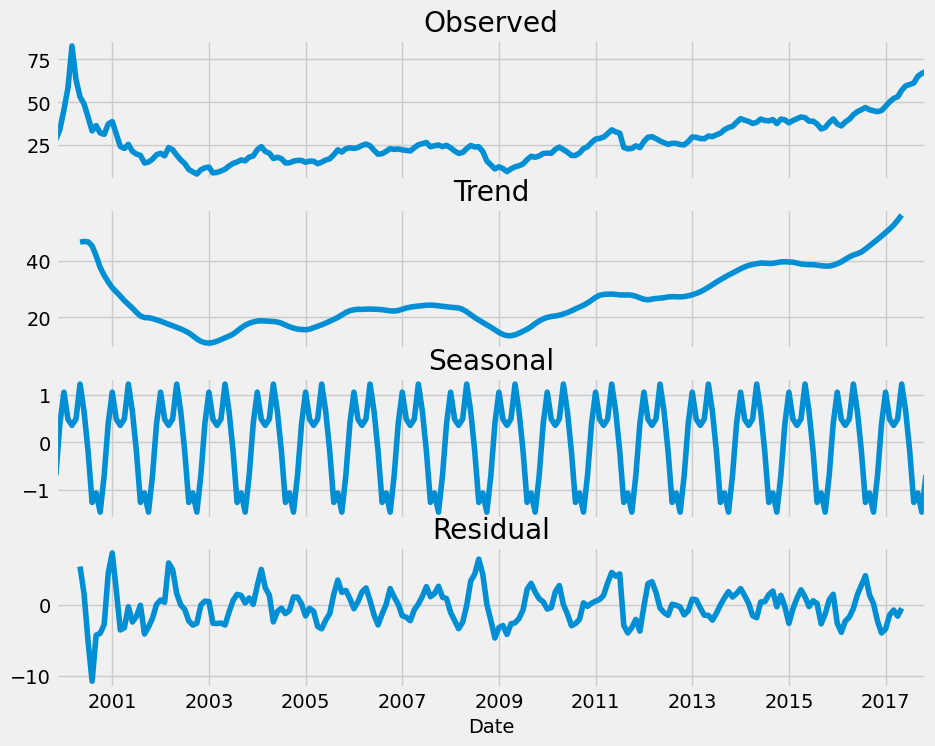

In [383]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform decomposition
result = seasonal_decompose(df, model='additive')  
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

result.observed.plot(ax=ax1, title='Observed')
result.trend.plot(ax=ax2, title='Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
result.resid.plot(ax=ax4, title='Residual')



##### Case 2: Multiplicative seasonal decomposition

<Axes: title={'center': 'Residual'}, xlabel='Date'>

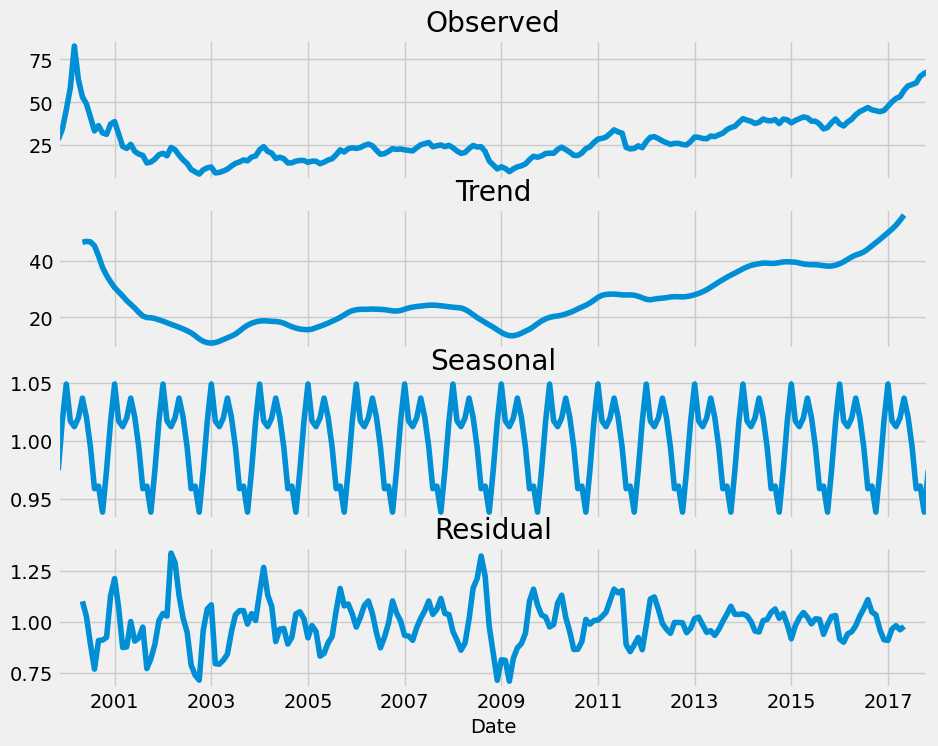

In [384]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform decomposition
result = seasonal_decompose(df, model='multiplicative')  
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

result.observed.plot(ax=ax1, title='Observed')
result.trend.plot(ax=ax2, title='Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
result.resid.plot(ax=ax4, title='Residual')



##### Simple Exponantial Smoothing

##### Split time series data into training and testing set

In [385]:
#split data into train and training set
train_data = df[0:int(len(df)*0.8)] # 80:20
test_data = df[int(len(df)*0.8):]

In [386]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
model = SimpleExpSmoothing(train_data)
model_fit = model.fit(smoothing_level=0.2,optimized=False)
model_fit.params

{'smoothing_level': 0.2,
 'smoothing_trend': None,
 'smoothing_seasonal': None,
 'damping_trend': nan,
 'initial_level': 28.262375,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [387]:
y_hat_ses = test_data.copy()
y_hat_ses = model_fit.forecast(24)

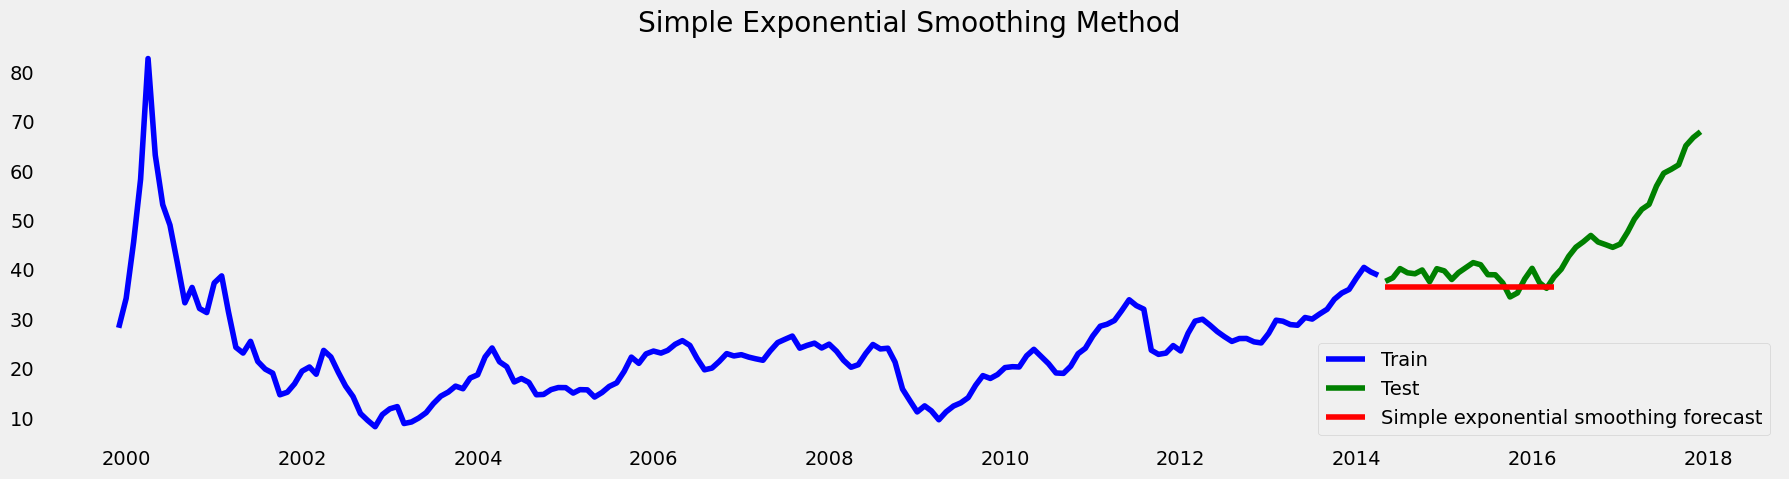

In [388]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train_data, label='Train', color='blue')
plt.plot(test_data, label='Test',color='green')
plt.plot(y_hat_ses, label='Simple exponential smoothing forecast',color='red')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

In [389]:
results = pd.DataFrame(columns=['Method', 'RMSE', 'MAPE'])

In [391]:
rmse = np.sqrt(mean_squared_error(test_data[:24], y_hat_ses)).round(2)
mape = np.round(np.mean(np.abs(test_data[:24]-y_hat_ses)/test_data[:24])*100,2)

In [392]:
tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Simple exponential smoothing forecast,2.75,6.25


##### Holt's Exponantial Smoothing

In [394]:
train= df[0:int(len(df)*0.8)] # 80:20
test = df[int(len(df)*0.8):]

In [415]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

model = ExponentialSmoothing(train ,seasonal_periods= seasonal_periods,trend='add', seasonal=None)
model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(model_fit.params)

{'smoothing_level': 0.2, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 46.33726236639025, 'initial_trend': 0.46959797679160886, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [416]:
y_hat_holt = test.copy()
y_hat_holt = model_fit.forecast(len(test))


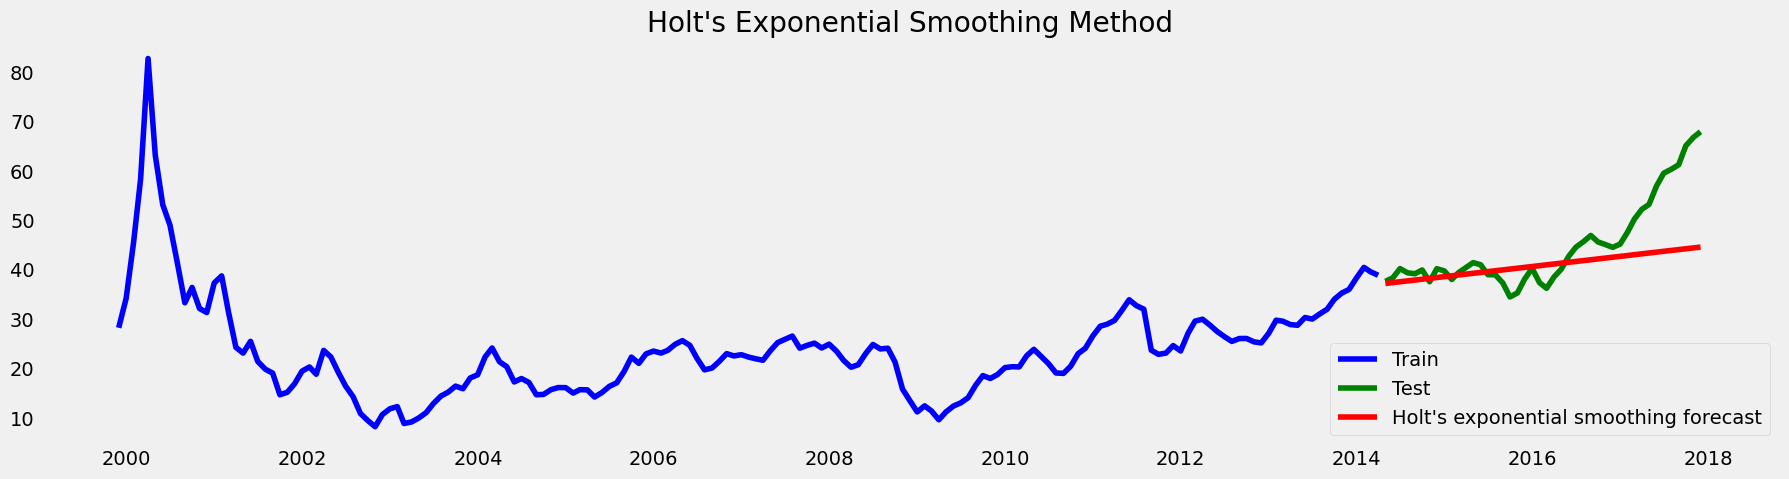

In [417]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train, label='Train', color='blue')
plt.plot(test, label='Test',color='green')
plt.plot(y_hat_holt, label='Holt\'s exponential smoothing forecast',color='red')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

In [404]:
rmse = np.sqrt(mean_squared_error(test[:len(test)], y_hat_holt)).round(2)
mape = np.round(np.mean(np.abs(test[:len(test)]-y_hat_holt)/test[:len(test)])*100,2)

In [405]:
tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Simple exponential smoothing forecast,2.75,6.25
0,Holt's exponential smoothing forecast,8.18,10.10


##### Winter's Exponential Smoothing

In [458]:
train_= df[0:int(len(df)*0.8)] # 80:20
test_ = df[int(len(df)*0.8):]

In [459]:
model = ExponentialSmoothing(train_ ,seasonal_periods=12,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa = test_.copy()
forecast_values = model_fit.forecast(len(test_))
y_hat_hwa = forecast_values

{'smoothing_level': 0.9999999850988388, 'smoothing_trend': 0.0, 'smoothing_seasonal': 5.087633866075821e-09, 'damping_trend': nan, 'initial_level': 31.61704384005315, 'initial_trend': 0.035507592843741005, 'initial_seasons': array([-3.39056171, -1.91615935, -0.21807716, -0.1070917 ,  1.14037021,
       -0.10370241, -0.62103363, -1.41840869, -2.45039273, -3.76534839,
       -3.43336172, -3.92739782]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


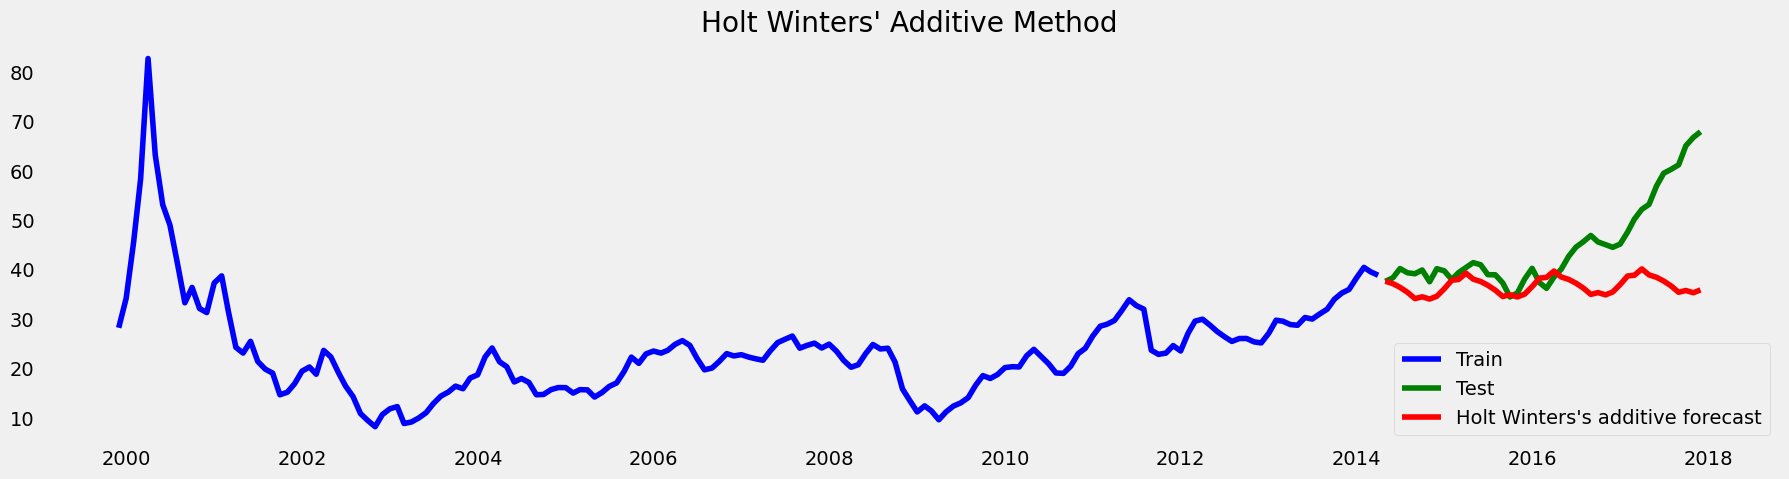

In [460]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot( train_, label='Train',color='blue')
plt.plot(test_, label='Test',color='green')
plt.plot(y_hat_hwa, label='Holt Winters\'s additive forecast',color='red')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

In [463]:

n_bootstraps = 1000  # Adjust as needed
forecasts = np.empty((n_bootstraps, len(y_hat_hwa)))
for i in range(n_bootstraps):
    # Bootstrapping with respect to time order
    indices = np.random.randint(0, len(train_), len(train_))
    resampled_data = train_.iloc[indices]  # Resample based on indices
    model = ExponentialSmoothing(resampled_data, seasonal_periods=12, trend='add', seasonal='add')
    model_fit = model.fit()
    forecasts[i] = model_fit.forecast(len(test_data))




In [464]:
forecasts

array([[23.47806429, 27.89701827, 26.98188695, ..., 24.13312448,
        23.79697613, 26.79824908],
       [22.85919767, 19.91544622, 20.24446019, ..., 20.57917832,
        19.14459676, 16.99523698],
       [22.97079138, 20.22350749, 20.75247382, ..., 21.26013824,
        19.76252368, 22.1382562 ],
       ...,
       [29.08873174, 22.50190943, 23.35474411, ..., 22.23126909,
        27.26947696, 23.34992625],
       [24.04031331, 20.99871108, 21.5204392 , ..., 24.30643183,
        28.08952956, 24.70013496],
       [22.04781371, 33.02238794, 23.59926   , ..., 27.04788831,
        27.2471309 , 22.11549569]])

In [ ]:
conf_int_lower = np.percentile(forecasts, 2.5, axis=0)
conf_int_upper = np.percentile(forecasts, 97.5, axis=0)



plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(train_, label='Train', color='blue')
plt.plot( test_, label='Test', color='green')
plt.plot( y_hat_hwa, label='Holt Winters\'s additive forecast', color='red')
plt.fill_between( y_hat_hwa.index, conf_int_lower, conf_int_upper, color='k',alpha=0.15,  label='95% Confidence Interval')
plt.legend(loc='best')
plt.title('Holt Winters\'s Additive Method with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)  # Rotate x-axis ticks for readability
plt.tight_layout()
plt.show()

#### 6. RandomForest

In [442]:
pip install statsmodels --upgrade

Note: you may need to restart the kernel to use updated packages.


#### 7. LSTM